In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import glob
import logging

import requests
from tqdm import tqdm, tqdm_notebook

import numpy as np
import pandas as pd

from dvidutils import LabelMapper
from libdvid import DVIDNodeService

from neuclease import configure_default_logging
from neuclease.dvid import *

In [22]:
##
## DELETE ME
##
def check_tarsupervoxels_status(server, uuid, instance, bodies):
    """
    For the given bodies, query the given tarsupervoxels instance and return a
    DataFrame indicating which supervoxels are 'missing' from the instance,
    along with their sizes.
    """
    body_sv_sizes = []
    for body in tqdm(bodies):
        try:
            missing_svs = fetch_missing(*master_node, 'segmentation_sv_meshes', body)
        except requests.RequestException as ex:
            if 'has no supervoxels' in ex.args[0]:
                continue
            else:
                raise

        sizes = fetch_sizes(*master_node, 'segmentation', missing_svs, supervoxels=True)
        body_sv_sizes += [(body, sv, size) for (sv, size) in zip(missing_svs, sizes)]

    df = pd.DataFrame(body_sv_sizes, columns=['body', 'sv', 'size'], dtype=np.uint64)
    df.set_index('sv', inplace=True)
    return df


In [8]:
pwd

'/nrs/flyem/bergs/complete-ffn-agglo'

In [15]:
master_node = ('emdata3:8900', '7254')

In [14]:
focused_bodies = pd.DataFrame(np.load('focused-7254-2tbars-2psds-10.0Mv.npy'))
focused_bodies.set_index('body', inplace=True)

# Filter for 0.5 criteria
focused_bodies.query('PostSyn >= 10 or PreSyn >= 2 or voxel_count >= 10e6', inplace=True)
print(f"Loaded {len(focused_bodies)} bodies")
focused_bodies.head()

Loaded 589420 bodies


,voxel_count,PostSyn,PreSyn
body,,,
1497973422,11823856010,8308,65
5813024096,10992947053,7393,111
262840563,10356857879,716,615
263199096,9677149202,51,36
262504004,8350396028,215,326


In [23]:
missing_sv_df = check_tarsupervoxels_status(*master_node, 'segmentation_sv_meshes', focused_bodies.index)


  0%|          | 2/589420 [00:05<436:59:28,  2.67s/it]
Exception in thread Thread-4:
Traceback (most recent call last):
  File "/groups/flyem/proj/cluster/miniforge/envs/flyem/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/groups/flyem/proj/cluster/miniforge/envs/flyem/lib/python3.6/site-packages/tqdm/_monitor.py", line 63, in run
    for instance in self.tqdm_cls._instances:
  File "/groups/flyem/proj/cluster/miniforge/envs/flyem/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration

100%|██████████| 589420/589420 [1:26:48<00:00, 113.16it/s]


In [24]:
missing_sv_df.to_csv('missing-focused-tarsupervoxels-7254.csv', index=True, header=True)

In [25]:
missing_sv_df.shape

(152538, 2)

In [26]:
missing_sv_df.head()

,body,size
sv,,
1814854285,1497973422,48
1784656557,1497973422,1320
1847425779,1497973422,48
1814526345,1497973422,58
1814888534,1497973422,40


In [30]:
pd.Series(pd.unique(missing_sv_df['body']), name='body').to_csv('missing-focused-tsv-bodies-7254.csv', index=False, header=True)

In [54]:
pd.unique(missing_sv_df['body']).shape

(45466,)

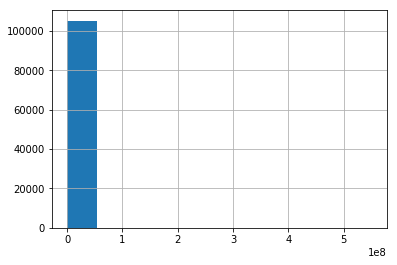

In [46]:
big_missing_svs = missing_sv_df.query('size > 50')
big_missing_svs['size'].hist()

big_missing_bodies = np.unique(big_missing_svs['body'])
pd.Series(big_missing_bodies, name='body').to_csv('missing-focused-tsv-bodies-7254.csv', index=False)

In [47]:
big_missing_bodies.shape

(21011,)

In [53]:
missing_sv_df['size'].sum() / 2**3

10122272876.0

In [51]:
missing_sv_df.query('size > 1e7')['size'].sort_values(ascending=False)

sv
941123943     549851174
2164060604    533071010
2012991506    495639457
1505352075    485443432
2128812711    463382121
2064851506    440595276
916828607     430570330
1283906702    405928027
1702318668    388694165
2137804660    386866514
1310408243    383404624
1590775989    379963891
1279740448    359639863
1049723094    332768718
1074727153    324537533
5322572807    318835592
893296225     317029625
1406682728    313512236
362037062     306531195
1352663924    304003653
1193901404    302774931
295133513     302551099
1344041939    286284276
953418430     274549491
452405459     265088856
976873647     264005516
2189289649    262527948
727522794     262059813
1560924689    261444490
760405490     256790073
                ...    
1165085866     10666476
1845647668     10660340
456510567      10653299
1807929630     10614665
1558031472     10613448
1592986563     10604835
1712748351     10576360
758367948      10565240
578663780      10564378
1134478349     10551655
1745294703   